# reference : https://www.kaggle.com/code/ammarnassanalhajali/layout-parser-model-training

In [1]:
!nvidia-smi


Wed Jan 25 11:08:13 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.65.01    Driver Version: 515.65.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A6000    Off  | 00000000:65:00.0 Off |                  Off |
| 30%   36C    P2    59W / 300W |   5943MiB / 49140MiB |    100%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
os.listdir('./')

['output_scratch_1ok',
 'test-coco.json',
 'badlad_dataset',
 'train-coco.json',
 '.ipynb_checkpoints',
 'detectron2',
 'BadLad_trainer.ipynb',
 'Bangla_DLA_trainer.ipynb',
 'coco-test.json',
 'train_badlad.py']

In [3]:
os.listdir('./badlad_dataset/')

['BDLAD_08',
 'BDLAD_07',
 'BDLAD_train_coco.json',
 'BDLAD_02',
 'BDLAD_01',
 'BDLAD_12',
 'BDLAD_test_coco.json',
 'BDLAD.json',
 'BDLAD_10',
 'BDLAD_09',
 'layoutparserweights',
 'all_imgs',
 'BDLAD_06',
 'BDLAD_11',
 'BDLAD_03',
 'BDLAD_04',
 'BDLAD_05']

In [4]:
!nvcc --version


nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


In [5]:
import torch, torchvision,numpy
print(torch.__version__, torch.cuda.is_available(),numpy.__version__) #1.13.1 True 1.23.5


1.10.0 True 1.23.5


# install detectron2

In [6]:
# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

# imports

In [7]:
import pandas as pd
import numpy as np
import pandas as pd 
from tqdm import tqdm
from tqdm import tqdm_notebook as tqdm # progress bar
from datetime import datetime
import time
import matplotlib.pyplot as plt
#from pycocotools.coco import COCO
import os, json, cv2, random
import skimage.io as io
import copy
from pathlib import Path
from typing import Optional


# torch
import torch

# Albumenatations
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

#from pycocotools.coco import COCO
from sklearn.model_selection import StratifiedKFold

# glob
from glob import glob

# numba
# import numba
# from numba import jit

import warnings
warnings.filterwarnings('ignore') #Ignore "future" warnings and Data-Frame-Slicing warnings.


# detectron2
from detectron2.structures import BoxMode
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.engine import DefaultPredictor, DefaultTrainer, launch
from detectron2.evaluation import COCOEvaluator
from detectron2.structures import BoxMode
from detectron2.utils.visualizer import ColorMode
from detectron2.utils.logger import setup_logger
from detectron2.utils.visualizer import Visualizer

from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader, build_detection_train_loader
from detectron2.data import detection_utils as utils


from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader, build_detection_train_loader
from detectron2.data import detection_utils as utils
import detectron2.data.transforms as T
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
import shutil
setup_logger()

<Logger detectron2 (DEBUG)>

In [8]:
train = True

debug= False #if False,train on full dataset otherwise use only 200 samples for training
pretrained = True #if true,then finetune using pretrained weights,otherwise train from scratch


imgdir="/home/ansary/Downloads/BadLad/badlad_dataset/all_imgs/"
train_coco = "/home/ansary/Downloads/BadLad/badlad_dataset/BDLAD_train_coco.json"
test_coco = "/home/ansary/Downloads/BadLad/badlad_dataset/BDLAD_test_coco.json"

if(train):
    if os.path.exists('./output'):
        print("removing  -> ",'./output')
        shutil.rmtree('./output')


Reference -> https://www.kaggle.com/code/ammarnassanalhajali/layout-parser-model-training

# load coco annotations

In [9]:
f = open(train_coco)
feval = open(test_coco)
thing_classes  = []
thing_classes_id = {}
data_annotations=[]

thing_classes_val  = []
thing_classes_id_val = {}
data_annotations_val=[]

data = json.load(f)
data_val = json.load(feval)

#----Images----
data_images=data['images']
data_images_val=data_val['images']

#---annotations train-
for i in data['annotations']:
    annot_obj ={"id": i['id'],"image_id": i['image_id'],"category_id":i['category_id'],
          "x_min":i['bbox'][0], #left
          "y_min":i['bbox'][1], #top
          "x_max":i['bbox'][0]+i['bbox'][2], #left+width
          "y_max":i['bbox'][1]+i['bbox'][3] #top+height
         }
    data_annotations.append(annot_obj) 

#---annotations eval-
for i in data_val['annotations']:
    annot_obj_eval ={"id": i['id'],"image_id": i['image_id'],"category_id":i['category_id'],
          "x_min":i['bbox'][0], #left
          "y_min":i['bbox'][1], #top
          "x_max":i['bbox'][0]+i['bbox'][2], #left+width
          "y_max":i['bbox'][1]+i['bbox'][3] #top+height
         }
    data_annotations_val.append(annot_obj_eval) 
    
    
#---categories train-
for i in data['categories']:
    thing_classes.append(i['name'])
    thing_classes_id[i['name']]=i['id']
f.close()

#---categories eval-
for i in data_val['categories']:
    thing_classes_val.append(i['name'])
    thing_classes_id_val[i['name']]=i['id']
feval.close()

print("thing_classes=",thing_classes)
print("thing_classes_id=",thing_classes_id)

print("thing_classes_val=",thing_classes_val)
print("thing_classes_id_val=",thing_classes_id_val)

thing_classes= ['paragraph', 'text_box', 'image', 'table']
thing_classes_id= {'paragraph': 0, 'text_box': 1, 'image': 2, 'table': 3}
thing_classes_val= ['paragraph', 'text_box', 'image', 'table']
thing_classes_id_val= {'paragraph': 0, 'text_box': 1, 'image': 2, 'table': 3}


In [10]:
# thing_classes= ['None','paragraph', 'text_box', 'image', 'table']
thing_classes= ['paragraph', 'text_box', 'image', 'table']

In [11]:
train_meta = pd.DataFrame(data_images)
train_meta = train_meta[['id', 'file_name', 'width', 'height']]
train_meta = train_meta.rename(columns={"id":"image_id"})
print("train_meta size=",len(train_meta))
train_meta.head(3)

train_meta size= 20367


,image_id,file_name,width,height
0,0,a4c953a8-70a9-4f9e-9c15-b82fcf0be537.png,720,995
1,1,554a63fb-1749-4a8a-84bc-3ed8a9724e04.png,1700,2800
2,2,ecdbeed5-b8ed-44bf-b23e-762debc8a79e.png,1700,2800


In [12]:
val_meta = pd.DataFrame(data_images_val)
val_meta = val_meta[['id', 'file_name', 'width', 'height']]
val_meta = val_meta.rename(columns={"id":"image_id"})
print("val_meta size=",len(val_meta))
val_meta.head(3)

val_meta size= 13328


,image_id,file_name,width,height
0,0,7755260c-42cf-48d1-9a79-0ffc154d9b63.png,3531,4995
1,1,e158046e-43d8-47eb-a9f1-3db7653764ac.png,1653,2339
2,2,4a47c322-eecd-4594-916c-50b0eddfcc0d.png,1653,2339


In [13]:
train_df = pd.DataFrame(data_annotations)
print("train_df size=",len(train_df))
train_df.head(3)

train_df size= 425109


,id,image_id,category_id,x_min,y_min,x_max,y_max
0,0,0,0,56.0,179.0,657.0,277.0
1,1,0,0,54.0,281.0,657.0,378.0
2,2,0,2,509.0,539.0,666.0,585.0


In [14]:
val_df = pd.DataFrame(data_annotations_val)
print("val_df size=",len(val_df))
val_df.head(3)

val_df size= 285139


,id,image_id,category_id,x_min,y_min,x_max,y_max
0,0,0,0,744.0,2490.0,2923.0,2721.0
1,1,0,2,266.0,69.0,3226.0,1329.0
2,2,0,2,2451.0,1558.0,2892.0,1861.0


In [15]:

split_mode="all_train" # all_train Or  valid20 
image_Width=768
image_Height=768


if debug:
    train_meta = train_meta.iloc[:200]  # For debug...
    val_meta = val_meta.iloc[:100]
len(train_meta),len(val_meta)

(20367, 13328)

# prepare and register data for detectron2

In [16]:
def get_PL_data_dicts(
    imgdir: Path,
    _train_df: pd.DataFrame,
    _train_meta: pd.DataFrame,
    use_cache: bool = True,
    target_indices: Optional[np.ndarray] = None,
    debug: bool = False,
    data_type:str="train"
   
):
    
    dataset_dicts = []
    for index, train_meta_row in tqdm(_train_meta.iterrows(), total=len(_train_meta)):
                    record = {}
                    image_id,file_name, width,height = train_meta_row.values
                    filename = str(f'{imgdir}/{file_name}')
                    record["file_name"] = filename
                    record["image_id"] = image_id
                    record["width"] = width
                    record["height"] = height
                    objs = []
                    for index2, row in _train_df.query("image_id == @image_id").iterrows():
                        class_id = row["category_id"]
                        bbox_resized = [
                            float(row["x_min"]),
                            float(row["y_min"]),
                            float(row["x_max"]),
                            float(row["y_max"]),
                        ]
                        obj = {
                            "bbox": bbox_resized,
                            "bbox_mode": BoxMode.XYXY_ABS,
                            "category_id": class_id,
                        }
                        objs.append(obj)
                    record["annotations"] = objs
                    dataset_dicts.append(record)
                    
    if target_indices is not None:
        dataset_dicts = [dataset_dicts[i] for i in target_indices]

    return dataset_dicts

In [17]:
%%time

Data_Resister_training="PL_data_train";
Data_Resister_valid="PL_data_valid";

if split_mode == "all_train":
    DatasetCatalog.register(
        Data_Resister_training,
        lambda: get_PL_data_dicts(
            imgdir,
            train_df,
            train_meta,
            debug=debug,
            data_type="train"
        ),
    )
    MetadataCatalog.get(Data_Resister_training).set(thing_classes=thing_classes)
    
    
    dataset_dicts_train = DatasetCatalog.get(Data_Resister_training)
    metadata_dicts_train = MetadataCatalog.get(Data_Resister_training)
    #eval
    DatasetCatalog.register(
        Data_Resister_valid,
        lambda: get_PL_data_dicts(
            imgdir,
            val_df,
            val_meta,
            debug=debug,
            data_type="val"
        ),
    )
    MetadataCatalog.get(Data_Resister_valid).set(thing_classes=thing_classes)
    
    
    dataset_dicts_valid = DatasetCatalog.get(Data_Resister_valid)
    metadata_dicts_valid = MetadataCatalog.get(Data_Resister_valid)
    
    
    
    
elif split_mode == "valid20":

    n_dataset = len(train_meta)
    n_train = int(n_dataset * 0.90)
    print("n_dataset", n_dataset, "n_train", n_train)
    rs = np.random.RandomState(12)
    inds = rs.permutation(n_dataset)
    train_inds, valid_inds = inds[:n_train], inds[n_train:]
    DatasetCatalog.register(
        Data_Resister_training,
        lambda: get_PL_data_dicts(
            imgdir,
            train_df,
            train_meta,
            target_indices=train_inds,
            debug=debug,
            data_type="train"
        ),
    )
    MetadataCatalog.get(Data_Resister_training).set(thing_classes=thing_classes)
    

    DatasetCatalog.register(
        Data_Resister_valid,
        lambda: get_PL_data_dicts(
            imgdir,
            train_df,
            train_meta,
            target_indices=valid_inds,
            debug=debug,
            data_type="val"
            ),
        )
    MetadataCatalog.get(Data_Resister_valid).set(thing_classes=thing_classes)
    
    dataset_dicts_train = DatasetCatalog.get(Data_Resister_training)
    metadata_dicts_train = MetadataCatalog.get(Data_Resister_training)

    dataset_dicts_valid = DatasetCatalog.get(Data_Resister_valid)
    metadata_dicts_valid = MetadataCatalog.get(Data_Resister_valid)
    
else:
    raise ValueError(f"[ERROR] Unexpected value split_mode={split_mode}")

  0%|          | 0/20367 [00:00<?, ?it/s]

  0%|          | 0/13328 [00:00<?, ?it/s]

CPU times: user 1min 29s, sys: 374 ms, total: 1min 29s
Wall time: 1min 29s


In [18]:
print("dicts training size=",len(dataset_dicts_train),"################  dicts valid size=",len(dataset_dicts_valid))

#print("dicts training size=",len(dataset_dicts_train))

dicts training size= 20367 ################  dicts valid size= 13328


In [19]:
dataset_dicts_train[5]

{'file_name': '/home/ansary/Downloads/BadLad/badlad_dataset/all_imgs//9f89a373-ca23-4a29-8fce-55a474dbde21.png',
 'image_id': 5,
 'width': 1202,
 'height': 1645,
 'annotations': [{'bbox': [122.0, 311.0, 1121.0, 422.0],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 0.0},
  {'bbox': [113.0, 405.0, 1011.0, 474.0],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 0.0},
  {'bbox': [131.0, 479.0, 1116.0, 555.0],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 0.0},
  {'bbox': [233.0, 34.0, 495.0, 262.0],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 2.0},
  {'bbox': [856.0, 580.0, 1103.0, 682.0],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 2.0},
  {'bbox': [469.0, 587.0, 848.0, 829.0],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 3.0},
  {'bbox': [702.0, 53.0, 1150.0, 341.0],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 3.0},
  {'bbox': [30.0, 18.0, 322.0, 310.0],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_i

# Augmentation

In [20]:
def custom_mapper(dataset_dict):
    
    dataset_dict = copy.deepcopy(dataset_dict)
    image = utils.read_image(dataset_dict["file_name"], format="BGR")
    transform_list = [T.RandomBrightness(0.8, 1.2),
                      T.RandomFlip(prob=0.5, horizontal=False, vertical=True),
                      T.RandomFlip(prob=0.5, horizontal=True, vertical=False)
                      ]
    image, transforms = T.apply_transform_gens(transform_list, image)
    dataset_dict["image"] = torch.as_tensor(image.transpose(2, 0, 1).astype("float32"))

    annos = [
        utils.transform_instance_annotations(obj, transforms, image.shape[:2])
        for obj in dataset_dict.pop("annotations")
        if obj.get("iscrowd", 0) == 0
    ]
    instances = utils.annotations_to_instances(annos, image.shape[:2])
    dataset_dict["instances"] = utils.filter_empty_instances(instances)
    return dataset_dict
class AugTrainer(DefaultTrainer):
    @classmethod
    def build_train_loader(cls, cfg):
        return build_detection_train_loader(cfg, mapper=custom_mapper)

# Train

In [21]:
%%time
print("training........")
cfg = get_cfg()
config_name = "COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml" 

# config_name = "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml" 

cfg.merge_from_file(model_zoo.get_config_file(config_name))

cfg.DATASETS.TRAIN = (Data_Resister_training,)

if split_mode == "all_train":
    cfg.DATASETS.TEST = ()
#     cfg.DATASETS.TEST = (Data_Resister_valid,)
    cfg.TEST.EVAL_PERIOD = 1000
else:
    cfg.DATASETS.TEST = (Data_Resister_valid,)
    cfg.TEST.EVAL_PERIOD = 1000

cfg.DATALOADER.NUM_WORKERS = 8
#cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(config_name)
if(pretrained):
    print("pretrained")
    cfg.MODEL.WEIGHTS="./badlad_dataset/layoutparserweights/PubLayNet_faster_rcnn_R_50_FPN_3x/PubLayNet_faster_rcnn_R_50_FPN_3x/model_final.pth"

cfg.SOLVER.AMP.ENABLED = True
cfg.SOLVER.IMS_PER_BATCH = 48
cfg.SOLVER.BASE_LR = 0.001

cfg.SOLVER.WARMUP_ITERS = 5
cfg.SOLVER.MAX_ITER = 10000 #adjust up if val mAP is still rising, adjust down if overfit
# cfg.SOLVER.STEPS = (500, 1000) # must be less than  MAX_ITER 
cfg.SOLVER.GAMMA = 0.05


cfg.SOLVER.CHECKPOINT_PERIOD = 1000  # Small value=Frequent save need a lot of storage.
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4


print("creating cfg.OUTPUT_DIR -> ",cfg.OUTPUT_DIR)
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)


#Training using custom trainer defined above
# trainer = AugTrainer(cfg) 
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
if(train):
    trainer.train()

training........
pretrained
creating cfg.OUTPUT_DIR ->  ./output
[01/25 11:09:55 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBat

  0%|          | 0/20367 [00:00<?, ?it/s]

[01/25 11:10:52 d2.data.build]: Removed 0 images with no usable annotations. 20367 images left.
[01/25 11:10:52 d2.data.build]: Distribution of instances among all 4 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
| paragraph  | 209588       |  text_box  | 203869       |   image    | 10297        |
|   table    | 1355         |            |              |            |              |
|   total    | 425109       |            |              |            |              |
[01/25 11:10:52 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[01/25 11:10:52 d2.data.build]: Using training sampler TrainingSampler
[01/25 11:10:52 d2.data.common]: Serializing 20367 elements to byte tensors and concatenating them all ...
[0

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (7, 1024) in the checkpoint but (5, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (7,) in the checkpoint but (5,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (24, 1024) in the checkpoint but (16, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (24,) in the checkpoint but (16,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weig

[01/25 11:10:54 d2.engine.train_loop]: Starting training from iteration 0
[01/25 11:11:58 d2.utils.events]:  eta: 8:43:46  iter: 19  total_loss: 1.81  loss_cls: 0.7054  loss_box_reg: 0.7224  loss_rpn_cls: 0.144  loss_rpn_loc: 0.2518  time: 3.1394  data_time: 1.3707  lr: 0.001  max_mem: 23486M
[01/25 11:13:07 d2.utils.events]:  eta: 8:56:44  iter: 39  total_loss: 1.454  loss_cls: 0.4793  loss_box_reg: 0.6394  loss_rpn_cls: 0.08362  loss_rpn_loc: 0.217  time: 3.2910  data_time: 1.6566  lr: 0.001  max_mem: 23486M
[01/25 11:14:18 d2.utils.events]:  eta: 9:02:26  iter: 59  total_loss: 1.252  loss_cls: 0.4239  loss_box_reg: 0.5626  loss_rpn_cls: 0.07483  loss_rpn_loc: 0.2077  time: 3.3841  data_time: 1.7381  lr: 0.001  max_mem: 23486M
[01/25 11:15:25 d2.utils.events]:  eta: 9:01:21  iter: 79  total_loss: 1.104  loss_cls: 0.3677  loss_box_reg: 0.4761  loss_rpn_cls: 0.05836  loss_rpn_loc: 0.1978  time: 3.3791  data_time: 1.5373  lr: 0.001  max_mem: 23486M
[01/25 11:16:33 d2.utils.events]:  eta

[01/25 11:53:40 d2.utils.events]:  eta: 8:34:17  iter: 759  total_loss: 0.8335  loss_cls: 0.2596  loss_box_reg: 0.3706  loss_rpn_cls: 0.04044  loss_rpn_loc: 0.163  time: 3.3748  data_time: 1.6822  lr: 0.001  max_mem: 23486M
[01/25 11:54:42 d2.utils.events]:  eta: 8:32:30  iter: 779  total_loss: 0.8523  loss_cls: 0.2703  loss_box_reg: 0.3694  loss_rpn_cls: 0.04033  loss_rpn_loc: 0.1667  time: 3.3676  data_time: 1.2806  lr: 0.001  max_mem: 23486M
[01/25 11:55:49 d2.utils.events]:  eta: 8:31:33  iter: 799  total_loss: 0.8578  loss_cls: 0.2655  loss_box_reg: 0.3753  loss_rpn_cls: 0.04641  loss_rpn_loc: 0.1699  time: 3.3664  data_time: 1.5147  lr: 0.001  max_mem: 23486M
[01/25 11:57:07 d2.utils.events]:  eta: 8:30:59  iter: 819  total_loss: 0.8362  loss_cls: 0.2637  loss_box_reg: 0.3705  loss_rpn_cls: 0.04467  loss_rpn_loc: 0.1713  time: 3.3795  data_time: 2.0844  lr: 0.001  max_mem: 23486M
[01/25 11:58:19 d2.utils.events]:  eta: 8:30:11  iter: 839  total_loss: 0.8384  loss_cls: 0.2538  los

[01/25 12:35:22 d2.utils.events]:  eta: 7:53:02  iter: 1499  total_loss: 0.7808  loss_cls: 0.2362  loss_box_reg: 0.3435  loss_rpn_cls: 0.03298  loss_rpn_loc: 0.1561  time: 3.3769  data_time: 1.5401  lr: 0.001  max_mem: 23486M
[01/25 12:36:29 d2.utils.events]:  eta: 7:51:51  iter: 1519  total_loss: 0.7921  loss_cls: 0.2487  loss_box_reg: 0.3488  loss_rpn_cls: 0.03363  loss_rpn_loc: 0.1583  time: 3.3768  data_time: 1.5538  lr: 0.001  max_mem: 23486M
[01/25 12:37:37 d2.utils.events]:  eta: 7:50:33  iter: 1539  total_loss: 0.7818  loss_cls: 0.2322  loss_box_reg: 0.3535  loss_rpn_cls: 0.0364  loss_rpn_loc: 0.1592  time: 3.3769  data_time: 1.5651  lr: 0.001  max_mem: 23486M
[01/25 12:38:49 d2.utils.events]:  eta: 7:49:00  iter: 1559  total_loss: 0.8039  loss_cls: 0.2456  loss_box_reg: 0.3587  loss_rpn_cls: 0.03522  loss_rpn_loc: 0.1593  time: 3.3800  data_time: 1.8065  lr: 0.001  max_mem: 23486M
[01/25 12:39:55 d2.utils.events]:  eta: 7:47:35  iter: 1579  total_loss: 0.7853  loss_cls: 0.2462

[01/25 13:17:36 d2.utils.events]:  eta: 7:12:51  iter: 2239  total_loss: 0.7756  loss_cls: 0.2366  loss_box_reg: 0.3488  loss_rpn_cls: 0.03099  loss_rpn_loc: 0.1609  time: 3.3922  data_time: 1.8768  lr: 0.001  max_mem: 23486M
[01/25 13:18:41 d2.utils.events]:  eta: 7:12:17  iter: 2259  total_loss: 0.7652  loss_cls: 0.2269  loss_box_reg: 0.3504  loss_rpn_cls: 0.03273  loss_rpn_loc: 0.1547  time: 3.3910  data_time: 1.4420  lr: 0.001  max_mem: 23486M
[01/25 13:19:49 d2.utils.events]:  eta: 7:11:23  iter: 2279  total_loss: 0.7642  loss_cls: 0.232  loss_box_reg: 0.3456  loss_rpn_cls: 0.03327  loss_rpn_loc: 0.1489  time: 3.3913  data_time: 1.6021  lr: 0.001  max_mem: 23486M
[01/25 13:20:55 d2.utils.events]:  eta: 7:10:16  iter: 2299  total_loss: 0.7707  loss_cls: 0.2332  loss_box_reg: 0.3494  loss_rpn_cls: 0.0337  loss_rpn_loc: 0.1586  time: 3.3904  data_time: 1.4626  lr: 0.001  max_mem: 23486M
[01/25 13:22:03 d2.utils.events]:  eta: 7:09:09  iter: 2319  total_loss: 0.7893  loss_cls: 0.2414 

[01/25 13:59:19 d2.utils.events]:  eta: 6:34:47  iter: 2979  total_loss: 0.7509  loss_cls: 0.227  loss_box_reg: 0.3476  loss_rpn_cls: 0.0284  loss_rpn_loc: 0.1483  time: 3.3897  data_time: 1.3636  lr: 0.001  max_mem: 23486M
[01/25 14:00:35 d2.utils.events]:  eta: 6:36:32  iter: 2999  total_loss: 0.745  loss_cls: 0.2294  loss_box_reg: 0.3394  loss_rpn_cls: 0.02855  loss_rpn_loc: 0.1472  time: 3.3924  data_time: 1.9778  lr: 0.001  max_mem: 23486M
[01/25 14:01:41 d2.utils.events]:  eta: 6:35:37  iter: 3019  total_loss: 0.7496  loss_cls: 0.2243  loss_box_reg: 0.3446  loss_rpn_cls: 0.03044  loss_rpn_loc: 0.1476  time: 3.3919  data_time: 1.4928  lr: 0.001  max_mem: 23486M
[01/25 14:02:48 d2.utils.events]:  eta: 6:35:25  iter: 3039  total_loss: 0.738  loss_cls: 0.2255  loss_box_reg: 0.3385  loss_rpn_cls: 0.03102  loss_rpn_loc: 0.1469  time: 3.3915  data_time: 1.5100  lr: 0.001  max_mem: 23486M
[01/25 14:03:52 d2.utils.events]:  eta: 6:33:46  iter: 3059  total_loss: 0.7574  loss_cls: 0.2342  l

[01/25 14:41:11 d2.utils.events]:  eta: 5:56:49  iter: 3719  total_loss: 0.7333  loss_cls: 0.219  loss_box_reg: 0.3386  loss_rpn_cls: 0.03255  loss_rpn_loc: 0.1452  time: 3.3905  data_time: 1.5025  lr: 0.001  max_mem: 23486M
[01/25 14:42:19 d2.utils.events]:  eta: 5:55:09  iter: 3739  total_loss: 0.7655  loss_cls: 0.2247  loss_box_reg: 0.3412  loss_rpn_cls: 0.03122  loss_rpn_loc: 0.1502  time: 3.3905  data_time: 1.5738  lr: 0.001  max_mem: 23486M
[01/25 14:43:28 d2.utils.events]:  eta: 5:53:53  iter: 3759  total_loss: 0.7274  loss_cls: 0.2165  loss_box_reg: 0.3403  loss_rpn_cls: 0.02835  loss_rpn_loc: 0.1437  time: 3.3908  data_time: 1.6168  lr: 0.001  max_mem: 23486M
[01/25 14:44:40 d2.utils.events]:  eta: 5:52:45  iter: 3779  total_loss: 0.7299  loss_cls: 0.2202  loss_box_reg: 0.3282  loss_rpn_cls: 0.02698  loss_rpn_loc: 0.1488  time: 3.3918  data_time: 1.7672  lr: 0.001  max_mem: 23486M
[01/25 14:45:47 d2.utils.events]:  eta: 5:51:30  iter: 3799  total_loss: 0.7503  loss_cls: 0.2237

[01/25 15:23:04 d2.utils.events]:  eta: 5:11:14  iter: 4459  total_loss: 0.7408  loss_cls: 0.2252  loss_box_reg: 0.3495  loss_rpn_cls: 0.02921  loss_rpn_loc: 0.1476  time: 3.3912  data_time: 1.7208  lr: 0.001  max_mem: 23486M
[01/25 15:24:15 d2.utils.events]:  eta: 5:10:07  iter: 4479  total_loss: 0.7271  loss_cls: 0.2242  loss_box_reg: 0.3423  loss_rpn_cls: 0.02791  loss_rpn_loc: 0.1436  time: 3.3919  data_time: 1.7160  lr: 0.001  max_mem: 23486M
[01/25 15:25:23 d2.utils.events]:  eta: 5:09:50  iter: 4499  total_loss: 0.7039  loss_cls: 0.2137  loss_box_reg: 0.339  loss_rpn_cls: 0.0247  loss_rpn_loc: 0.1354  time: 3.3920  data_time: 1.5953  lr: 0.001  max_mem: 23486M
[01/25 15:26:29 d2.utils.events]:  eta: 5:07:37  iter: 4519  total_loss: 0.7329  loss_cls: 0.2124  loss_box_reg: 0.3399  loss_rpn_cls: 0.02975  loss_rpn_loc: 0.1441  time: 3.3916  data_time: 1.4846  lr: 0.001  max_mem: 23486M
[01/25 15:27:35 d2.utils.events]:  eta: 5:06:18  iter: 4539  total_loss: 0.7412  loss_cls: 0.228  

[01/25 16:04:48 d2.utils.events]:  eta: 4:28:26  iter: 5199  total_loss: 0.7314  loss_cls: 0.2162  loss_box_reg: 0.3337  loss_rpn_cls: 0.0296  loss_rpn_loc: 0.1412  time: 3.3899  data_time: 1.5235  lr: 0.001  max_mem: 23486M
[01/25 16:06:05 d2.utils.events]:  eta: 4:27:19  iter: 5219  total_loss: 0.7492  loss_cls: 0.2271  loss_box_reg: 0.3389  loss_rpn_cls: 0.02728  loss_rpn_loc: 0.1501  time: 3.3918  data_time: 2.0364  lr: 0.001  max_mem: 23486M
[01/25 16:07:13 d2.utils.events]:  eta: 4:26:38  iter: 5239  total_loss: 0.7428  loss_cls: 0.2216  loss_box_reg: 0.3374  loss_rpn_cls: 0.02979  loss_rpn_loc: 0.1442  time: 3.3917  data_time: 1.5580  lr: 0.001  max_mem: 23486M
[01/25 16:08:21 d2.utils.events]:  eta: 4:25:14  iter: 5259  total_loss: 0.7051  loss_cls: 0.2109  loss_box_reg: 0.3338  loss_rpn_cls: 0.02808  loss_rpn_loc: 0.1405  time: 3.3918  data_time: 1.6015  lr: 0.001  max_mem: 23486M
[01/25 16:09:29 d2.utils.events]:  eta: 4:24:23  iter: 5279  total_loss: 0.7124  loss_cls: 0.2145

[01/25 16:46:33 d2.utils.events]:  eta: 3:45:46  iter: 5939  total_loss: 0.7291  loss_cls: 0.2182  loss_box_reg: 0.3309  loss_rpn_cls: 0.0279  loss_rpn_loc: 0.1487  time: 3.3893  data_time: 1.4430  lr: 0.001  max_mem: 23486M
[01/25 16:47:41 d2.utils.events]:  eta: 3:45:09  iter: 5959  total_loss: 0.706  loss_cls: 0.2146  loss_box_reg: 0.3274  loss_rpn_cls: 0.027  loss_rpn_loc: 0.1358  time: 3.3893  data_time: 1.5631  lr: 0.001  max_mem: 23486M
[01/25 16:48:45 d2.utils.events]:  eta: 3:44:13  iter: 5979  total_loss: 0.6801  loss_cls: 0.1988  loss_box_reg: 0.3247  loss_rpn_cls: 0.02322  loss_rpn_loc: 0.1364  time: 3.3888  data_time: 1.4120  lr: 0.001  max_mem: 23486M
[01/25 16:49:55 d2.utils.events]:  eta: 3:42:40  iter: 5999  total_loss: 0.7211  loss_cls: 0.211  loss_box_reg: 0.3339  loss_rpn_cls: 0.02858  loss_rpn_loc: 0.1383  time: 3.3890  data_time: 1.6288  lr: 0.001  max_mem: 23486M
[01/25 16:51:03 d2.utils.events]:  eta: 3:41:33  iter: 6019  total_loss: 0.7211  loss_cls: 0.218  los

[01/25 17:28:31 d2.utils.events]:  eta: 3:06:12  iter: 6679  total_loss: 0.7222  loss_cls: 0.214  loss_box_reg: 0.3396  loss_rpn_cls: 0.02764  loss_rpn_loc: 0.1405  time: 3.3907  data_time: 1.3364  lr: 0.001  max_mem: 23486M
[01/25 17:29:37 d2.utils.events]:  eta: 3:04:40  iter: 6699  total_loss: 0.7154  loss_cls: 0.2169  loss_box_reg: 0.3377  loss_rpn_cls: 0.02587  loss_rpn_loc: 0.1439  time: 3.3904  data_time: 1.4492  lr: 0.001  max_mem: 23486M
[01/25 17:30:48 d2.utils.events]:  eta: 3:04:08  iter: 6719  total_loss: 0.7005  loss_cls: 0.2109  loss_box_reg: 0.3332  loss_rpn_cls: 0.02695  loss_rpn_loc: 0.1424  time: 3.3909  data_time: 1.7366  lr: 0.001  max_mem: 23486M
[01/25 17:31:53 d2.utils.events]:  eta: 3:02:50  iter: 6739  total_loss: 0.7192  loss_cls: 0.2197  loss_box_reg: 0.3305  loss_rpn_cls: 0.02736  loss_rpn_loc: 0.1381  time: 3.3904  data_time: 1.4044  lr: 0.001  max_mem: 23486M
[01/25 17:32:57 d2.utils.events]:  eta: 3:01:19  iter: 6759  total_loss: 0.7068  loss_cls: 0.2122

[01/25 18:10:23 d2.utils.events]:  eta: 2:25:33  iter: 7419  total_loss: 0.6969  loss_cls: 0.2083  loss_box_reg: 0.3338  loss_rpn_cls: 0.02615  loss_rpn_loc: 0.1345  time: 3.3910  data_time: 1.3413  lr: 0.001  max_mem: 23486M
[01/25 18:11:35 d2.utils.events]:  eta: 2:24:23  iter: 7439  total_loss: 0.714  loss_cls: 0.219  loss_box_reg: 0.333  loss_rpn_cls: 0.02729  loss_rpn_loc: 0.1456  time: 3.3915  data_time: 1.7768  lr: 0.001  max_mem: 23486M
[01/25 18:12:40 d2.utils.events]:  eta: 2:23:18  iter: 7459  total_loss: 0.6981  loss_cls: 0.2106  loss_box_reg: 0.3324  loss_rpn_cls: 0.02722  loss_rpn_loc: 0.1358  time: 3.3912  data_time: 1.4413  lr: 0.001  max_mem: 23486M
[01/25 18:13:46 d2.utils.events]:  eta: 2:22:10  iter: 7479  total_loss: 0.7014  loss_cls: 0.2104  loss_box_reg: 0.3241  loss_rpn_cls: 0.02732  loss_rpn_loc: 0.1402  time: 3.3908  data_time: 1.4506  lr: 0.001  max_mem: 23486M
[01/25 18:14:53 d2.utils.events]:  eta: 2:20:40  iter: 7499  total_loss: 0.6954  loss_cls: 0.2124  

[01/25 18:52:13 d2.utils.events]:  eta: 1:43:06  iter: 8159  total_loss: 0.7226  loss_cls: 0.2168  loss_box_reg: 0.3278  loss_rpn_cls: 0.02675  loss_rpn_loc: 0.1463  time: 3.3909  data_time: 1.6505  lr: 0.001  max_mem: 23486M
[01/25 18:53:19 d2.utils.events]:  eta: 1:41:50  iter: 8179  total_loss: 0.7095  loss_cls: 0.2051  loss_box_reg: 0.333  loss_rpn_cls: 0.02511  loss_rpn_loc: 0.1339  time: 3.3906  data_time: 1.4548  lr: 0.001  max_mem: 23486M
[01/25 18:54:30 d2.utils.events]:  eta: 1:40:24  iter: 8199  total_loss: 0.728  loss_cls: 0.22  loss_box_reg: 0.3407  loss_rpn_cls: 0.02605  loss_rpn_loc: 0.1418  time: 3.3911  data_time: 1.7635  lr: 0.001  max_mem: 23486M
[01/25 18:55:49 d2.utils.events]:  eta: 1:39:43  iter: 8219  total_loss: 0.6636  loss_cls: 0.1893  loss_box_reg: 0.3163  loss_rpn_cls: 0.02273  loss_rpn_loc: 0.1322  time: 3.3924  data_time: 2.1116  lr: 0.001  max_mem: 23486M
[01/25 18:56:54 d2.utils.events]:  eta: 1:38:30  iter: 8239  total_loss: 0.6916  loss_cls: 0.2004  l

[01/25 19:34:09 d2.utils.events]:  eta: 1:02:11  iter: 8899  total_loss: 0.7312  loss_cls: 0.2162  loss_box_reg: 0.3347  loss_rpn_cls: 0.02755  loss_rpn_loc: 0.1399  time: 3.3916  data_time: 1.3203  lr: 0.001  max_mem: 23486M
[01/25 19:35:22 d2.utils.events]:  eta: 1:01:01  iter: 8919  total_loss: 0.7054  loss_cls: 0.209  loss_box_reg: 0.3306  loss_rpn_cls: 0.02716  loss_rpn_loc: 0.135  time: 3.3922  data_time: 1.8138  lr: 0.001  max_mem: 23486M
[01/25 19:36:27 d2.utils.events]:  eta: 0:59:43  iter: 8939  total_loss: 0.7016  loss_cls: 0.2133  loss_box_reg: 0.3312  loss_rpn_cls: 0.02901  loss_rpn_loc: 0.1304  time: 3.3918  data_time: 1.4181  lr: 0.001  max_mem: 23486M
[01/25 19:37:28 d2.utils.events]:  eta: 0:58:34  iter: 8959  total_loss: 0.7024  loss_cls: 0.2041  loss_box_reg: 0.3307  loss_rpn_cls: 0.02601  loss_rpn_loc: 0.1402  time: 3.3912  data_time: 1.2605  lr: 0.001  max_mem: 23486M
[01/25 19:38:35 d2.utils.events]:  eta: 0:57:31  iter: 8979  total_loss: 0.6993  loss_cls: 0.2115 

[01/25 20:15:39 d2.utils.events]:  eta: 0:20:01  iter: 9639  total_loss: 0.7039  loss_cls: 0.2063  loss_box_reg: 0.3301  loss_rpn_cls: 0.02282  loss_rpn_loc: 0.1333  time: 3.3895  data_time: 1.4296  lr: 0.001  max_mem: 23486M
[01/25 20:16:47 d2.utils.events]:  eta: 0:18:51  iter: 9659  total_loss: 0.7087  loss_cls: 0.2061  loss_box_reg: 0.3243  loss_rpn_cls: 0.02971  loss_rpn_loc: 0.1425  time: 3.3895  data_time: 1.5749  lr: 0.001  max_mem: 23486M
[01/25 20:17:52 d2.utils.events]:  eta: 0:17:44  iter: 9679  total_loss: 0.6931  loss_cls: 0.208  loss_box_reg: 0.3246  loss_rpn_cls: 0.02435  loss_rpn_loc: 0.1374  time: 3.3892  data_time: 1.4490  lr: 0.001  max_mem: 23486M
[01/25 20:18:58 d2.utils.events]:  eta: 0:16:37  iter: 9699  total_loss: 0.6782  loss_cls: 0.1993  loss_box_reg: 0.3284  loss_rpn_cls: 0.02592  loss_rpn_loc: 0.1357  time: 3.3890  data_time: 1.4557  lr: 0.001  max_mem: 23486M
[01/25 20:20:03 d2.utils.events]:  eta: 0:15:28  iter: 9719  total_loss: 0.6963  loss_cls: 0.2116

# Evaluation

In [22]:
%%time
print("Evaluating........")

evaluator = COCOEvaluator(Data_Resister_valid, cfg, False, output_dir="./output/")
cfg.MODEL.WEIGHTS="./output/model_final.pth"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold
val_loader = build_detection_test_loader(cfg, Data_Resister_valid)
inference_on_dataset(trainer.model, val_loader, evaluator)

#https://github.com/facebookresearch/detectron2/issues/1631

Evaluating........
WARNING [01/25 20:36:01 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[01/25 20:36:01 d2.evaluation.coco_evaluation]: Trying to convert 'PL_data_valid' to COCO format ...
[01/25 20:36:01 d2.data.datasets.coco]: Converting annotations of dataset 'PL_data_valid' to COCO format ...)


  0%|          | 0/13328 [00:00<?, ?it/s]

[01/25 20:36:33 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[01/25 20:37:01 d2.data.datasets.coco]: Conversion finished, #images: 13328, #annotations: 285139
[01/25 20:37:02 d2.data.datasets.coco]: Caching COCO format annotations at './output/PL_data_valid_coco_format.json' ...


  0%|          | 0/13328 [00:00<?, ?it/s]

[01/25 20:37:39 d2.data.build]: Distribution of instances among all 4 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
| paragraph  | 136331       |  text_box  | 140380       |   image    | 7452         |
|   table    | 976          |            |              |            |              |
|   total    | 285139       |            |              |            |              |
[01/25 20:37:39 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[01/25 20:37:39 d2.data.common]: Serializing 13328 elements to byte tensors and concatenating them all ...
[01/25 20:37:39 d2.data.common]: Serialized dataset takes 23.62 MiB
[01/25 20:37:39 d2.evaluation.evaluator]: Start inference on 13328 batches
[01/25 20:37:42 d2.evaluation.evaluator]: Inference done 11

[01/25 20:41:11 d2.evaluation.evaluator]: Inference done 4398/13328. Dataloading: 0.0170 s/iter. Inference: 0.0303 s/iter. Eval: 0.0003 s/iter. Total: 0.0476 s/iter. ETA=0:07:05
[01/25 20:41:16 d2.evaluation.evaluator]: Inference done 4494/13328. Dataloading: 0.0171 s/iter. Inference: 0.0303 s/iter. Eval: 0.0003 s/iter. Total: 0.0477 s/iter. ETA=0:07:01
[01/25 20:41:21 d2.evaluation.evaluator]: Inference done 4607/13328. Dataloading: 0.0171 s/iter. Inference: 0.0303 s/iter. Eval: 0.0003 s/iter. Total: 0.0478 s/iter. ETA=0:06:56
[01/25 20:41:27 d2.evaluation.evaluator]: Inference done 4648/13328. Dataloading: 0.0178 s/iter. Inference: 0.0304 s/iter. Eval: 0.0003 s/iter. Total: 0.0485 s/iter. ETA=0:07:00
[01/25 20:41:32 d2.evaluation.evaluator]: Inference done 4724/13328. Dataloading: 0.0181 s/iter. Inference: 0.0304 s/iter. Eval: 0.0003 s/iter. Total: 0.0488 s/iter. ETA=0:06:59
[01/25 20:41:37 d2.evaluation.evaluator]: Inference done 4828/13328. Dataloading: 0.0181 s/iter. Inference: 0.

[01/25 20:45:10 d2.evaluation.evaluator]: Inference done 9386/13328. Dataloading: 0.0170 s/iter. Inference: 0.0305 s/iter. Eval: 0.0002 s/iter. Total: 0.0478 s/iter. ETA=0:03:08
[01/25 20:45:15 d2.evaluation.evaluator]: Inference done 9515/13328. Dataloading: 0.0169 s/iter. Inference: 0.0305 s/iter. Eval: 0.0002 s/iter. Total: 0.0477 s/iter. ETA=0:03:01
[01/25 20:45:20 d2.evaluation.evaluator]: Inference done 9645/13328. Dataloading: 0.0168 s/iter. Inference: 0.0305 s/iter. Eval: 0.0002 s/iter. Total: 0.0476 s/iter. ETA=0:02:55
[01/25 20:45:25 d2.evaluation.evaluator]: Inference done 9780/13328. Dataloading: 0.0166 s/iter. Inference: 0.0306 s/iter. Eval: 0.0002 s/iter. Total: 0.0475 s/iter. ETA=0:02:48
[01/25 20:45:30 d2.evaluation.evaluator]: Inference done 9907/13328. Dataloading: 0.0165 s/iter. Inference: 0.0305 s/iter. Eval: 0.0002 s/iter. Total: 0.0474 s/iter. ETA=0:02:42
[01/25 20:45:35 d2.evaluation.evaluator]: Inference done 10038/13328. Dataloading: 0.0164 s/iter. Inference: 0

CPU times: user 1h 42min 38s, sys: 2min 39s, total: 1h 45min 18s
Wall time: 12min 1s


OrderedDict([('bbox',
              {'AP': 46.84044790216401,
               'AP50': 66.97311146787032,
               'AP75': 50.002093354336274,
               'APs': 7.5824797852420565,
               'APm': 21.112284942219304,
               'APl': 51.63523802508492,
               'AP-paragraph': 67.86145406367176,
               'AP-text_box': 24.788794921491515,
               'AP-image': 53.237384152513876,
               'AP-table': 41.4741584709789})])

# Save records

In [23]:
metrics_df = pd.read_json("./output/metrics.json", orient="records", lines=True)
mdf = metrics_df.sort_values("iteration")
mdf.head(10).T

,0,1,2,3,4,5,6,7,8,9
data_time,1.353558,1.529195,1.576724,1.505920,1.743272,1.318212,1.445117,1.548552,1.623127,1.465995
eta_seconds,31426.146403,32204.712572,32546.956772,32481.469938,32540.415973,32350.496269,32285.009434,32447.995347,32402.343647,32336.351094
fast_rcnn/cls_accuracy,0.767008,0.822673,0.844889,0.867432,0.872233,0.876546,0.878418,0.887614,0.882406,0.876302
fast_rcnn/false_negative,0.740741,0.432988,0.365858,0.329312,0.325521,0.303590,0.287352,0.270714,0.292318,0.294258
fast_rcnn/fg_cls_accuracy,0.137704,0.483508,0.580439,0.620439,0.618164,0.640131,0.659540,0.688040,0.668620,0.650521
iteration,19.000000,39.000000,59.000000,79.000000,99.000000,119.000000,139.000000,159.000000,179.000000,199.000000
loss_box_reg,0.722367,0.639411,0.562581,0.476076,0.441929,0.433912,0.414693,0.411295,0.415754,0.419969
loss_cls,0.705406,0.479307,0.423877,0.367696,0.354407,0.332121,0.325177,0.307421,0.315272,0.323567
loss_rpn_cls,0.144001,0.083619,0.074829,0.058359,0.062053,0.060731,0.059081,0.049973,0.056711,0.050033
loss_rpn_loc,0.251838,0.217009,0.207684,0.197790,0.190766,0.180469,0.180346,0.178779,0.184126,0.185014


# Loss and Accuracy Plots

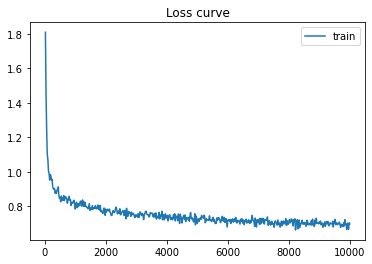

In [24]:
fig, ax = plt.subplots()

mdf1 = mdf[~mdf["total_loss"].isna()]
ax.plot(mdf1["iteration"], mdf1["total_loss"], c="C0", label="train")
if "validation_loss" in mdf.columns:
    mdf2 = mdf[~mdf["validation_loss"].isna()]
    ax.plot(mdf2["iteration"], mdf2["validation_loss"], c="C1", label="validation")

# ax.set_ylim([0, 0.5])
ax.legend()
ax.set_title("Loss curve")
plt.show()

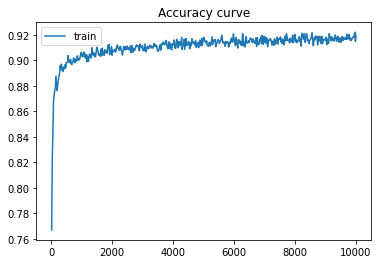

In [25]:
fig, ax = plt.subplots()

mdf1 = mdf[~mdf["fast_rcnn/cls_accuracy"].isna()]
ax.plot(mdf1["iteration"], mdf1["fast_rcnn/cls_accuracy"], c="C0", label="train")
# ax.set_ylim([0, 0.5])
ax.legend()
ax.set_title("Accuracy curve")
plt.show()

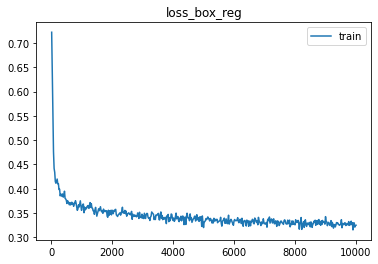

In [26]:
fig, ax = plt.subplots()
mdf1 = mdf[~mdf["loss_box_reg"].isna()]
ax.plot(mdf1["iteration"], mdf1["loss_box_reg"], c="C0", label="train")
# ax.set_ylim([0, 0.5])
ax.legend()
ax.set_title("loss_box_reg")
plt.show()

# Inference

In [27]:
# !pip install -U layoutparser 

In [28]:
import layoutparser as lp
import cv2


Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (5, 1024) in the checkpoint but (7, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (5,) in the checkpoint but (7,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (16, 1024) in the checkpoint but (24, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (16,) in the checkpoint but (24,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weig

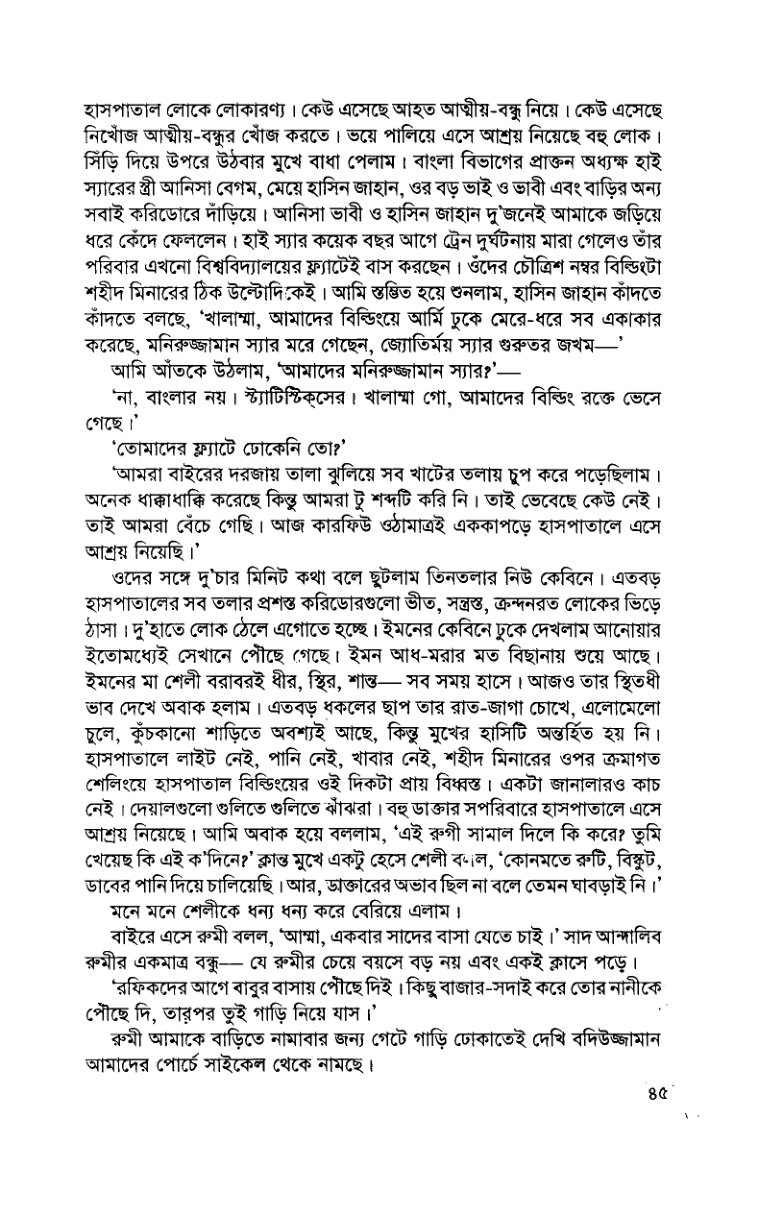

In [29]:
model = lp.Detectron2LayoutModel('lp://PubLayNet/faster_rcnn_R_50_FPN_3x/config',
                                 './output/model_final.pth',
                                 extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.5],
                                 label_map={0: "paragraph", 1: "text_box", 2: "image", 3:"table"})
#######################################################
image = cv2.imread('/home/ansary/Downloads/BadLad/badlad_dataset/BDLAD_01/BDLAD_Train/97ddeb35-e310-46e0-98e5-d71a1be53b5a.png')
#plt.imshow(image)
color_map = {
    'text_box':   'red',
    'paragraph':  'blue',
    'image':   'green',
    'table':  'yellow',

}

layout_predicted = model.detect(image)
lp.draw_box(image,
              [b.set(id=f'{b.type}/{b.score:.2f}') for b in layout_predicted],
              color_map=color_map,
              show_element_id=True, id_font_size=10,
              id_text_background_color='black',
              id_text_color='white')

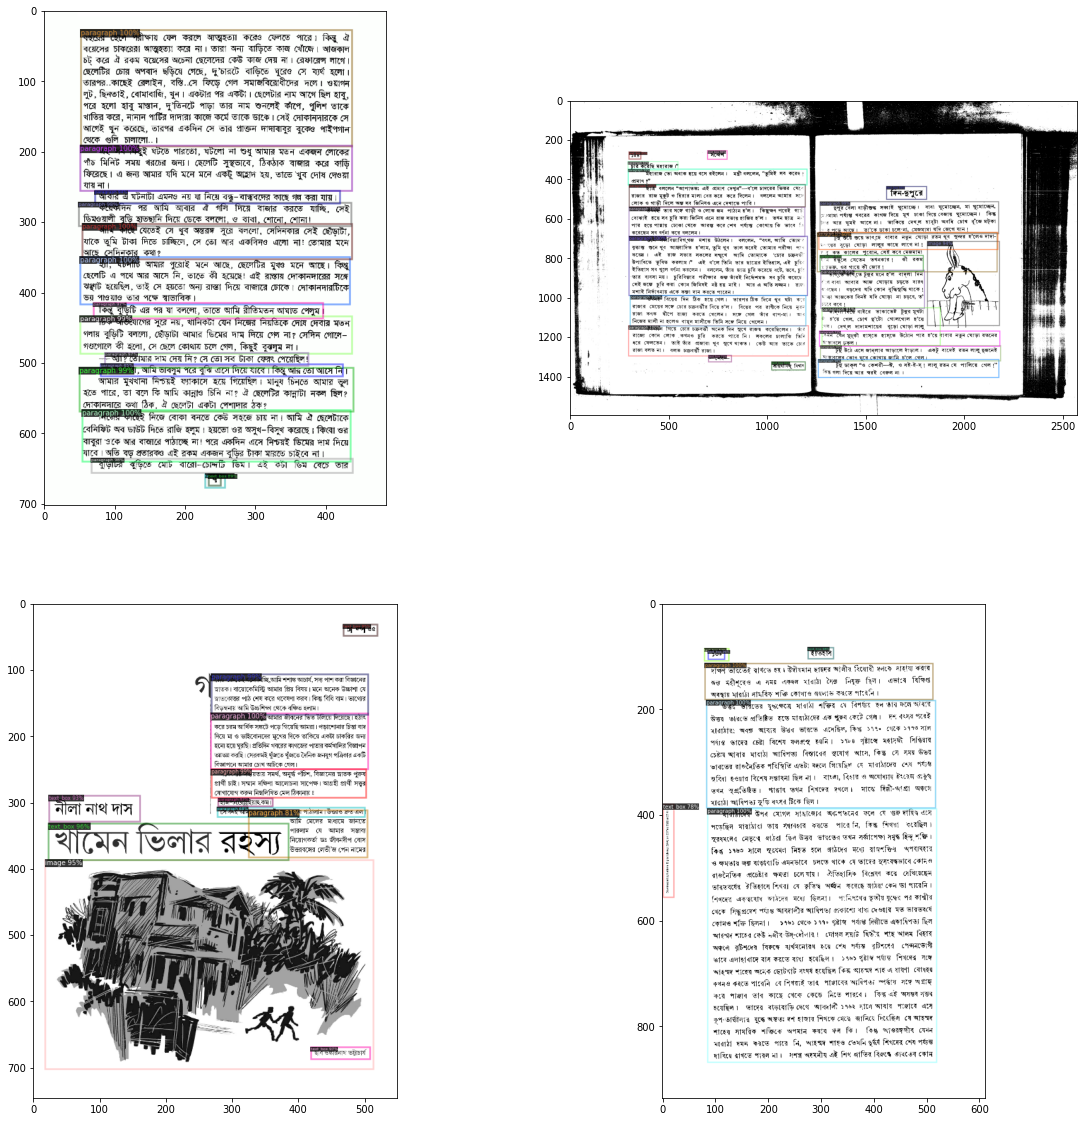

In [30]:
cfg.MODEL.WEIGHTS = "./output/model_final.pth"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold for this model
#cfg.DATASETS.TEST = ("Data_Resister_training", )
predictor = DefaultPredictor(cfg)

###############################################################

fig, ax = plt.subplots(2, 2, figsize =(20,20))
indices=[ax[0][0],ax[1][0],ax[0][1],ax[1][1] ]
i=-1
# Show some qualitative results by predicting on test set images
NUM_TEST_SAMPLES = 4
samples = random.sample(dataset_dicts_train, NUM_TEST_SAMPLES)
for i, sample in enumerate(samples):
    img = cv2.imread(sample["file_name"])
    outputs = predictor(img)
    visualizer = Visualizer(img, metadata=metadata_dicts_train,scale=0.5,)
    visualizer = visualizer.draw_instance_predictions(
        outputs["instances"].to("cpu"))
    display_img = visualizer.get_image()[:, :, ::-1]
    indices[i].grid(False)
    indices[i].imshow(display_img)

In [31]:

#total epochs https://stackoverflow.com/questions/63578040/how-many-images-per-iteration-in-detectron2
cfg.SOLVER.MAX_ITER * cfg.SOLVER.IMS_PER_BATCH / len(train_meta)

23.567535719546324

In [32]:
iterations_for_one_epoch = len(train_meta) / cfg.SOLVER.IMS_PER_BATCH
iterations_for_one_epoch * 1 # == 1 epoch

424.3125

In [33]:
print(cfg)

CUDNN_BENCHMARK: False
DATALOADER:
  ASPECT_RATIO_GROUPING: True
  FILTER_EMPTY_ANNOTATIONS: True
  NUM_WORKERS: 8
  REPEAT_THRESHOLD: 0.0
  SAMPLER_TRAIN: TrainingSampler
DATASETS:
  PRECOMPUTED_PROPOSAL_TOPK_TEST: 1000
  PRECOMPUTED_PROPOSAL_TOPK_TRAIN: 2000
  PROPOSAL_FILES_TEST: ()
  PROPOSAL_FILES_TRAIN: ()
  TEST: ()
  TRAIN: ('PL_data_train',)
GLOBAL:
  HACK: 1.0
INPUT:
  CROP:
    ENABLED: False
    SIZE: [0.9, 0.9]
    TYPE: relative_range
  FORMAT: BGR
  MASK_FORMAT: polygon
  MAX_SIZE_TEST: 1333
  MAX_SIZE_TRAIN: 1333
  MIN_SIZE_TEST: 800
  MIN_SIZE_TRAIN: (640, 672, 704, 736, 768, 800)
  MIN_SIZE_TRAIN_SAMPLING: choice
  RANDOM_FLIP: horizontal
MODEL:
  ANCHOR_GENERATOR:
    ANGLES: [[-90, 0, 90]]
    ASPECT_RATIOS: [[0.5, 1.0, 2.0]]
    NAME: DefaultAnchorGenerator
    OFFSET: 0.0
    SIZES: [[32], [64], [128], [256], [512]]
  BACKBONE:
    FREEZE_AT: 2
    NAME: build_resnet_fpn_backbone
  DEVICE: cuda
  FPN:
    FUSE_TYPE: sum
    IN_FEATURES: ['res2', 'res3', 'res4', 'r